# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import  Counter

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

In [3]:
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
num_rows, num_col = azdias.shape
print("There are %s rows and %s columns" %(num_rows, num_col))
azdias.head(10)

There are 891221 rows and 85 columns


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [6]:
# Identify missing or unknown data values and convert them to NaNs.
for col in range(azdias.shape[1]):
    col_name=azdias.columns[col]
    na_list=feat_info.iloc[col,3]
    na_list=na_list.replace('[', '')
    na_list=na_list.replace(']', '')
    na_list=na_list.split(',')
    if na_list == ['']:
        continue
    else:
        for na_value in na_list:
            if azdias[col_name].dtype =='object':
                azdias.loc[azdias[col_name]==na_value,col_name]=np.nan 
            else:   
                na_value=int(na_value)
                azdias.loc[azdias[col_name]==na_value,col_name]=np.nan

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [7]:
azdias.to_csv('azdias_converted.csv', sep=';', index = False)

In [8]:
# Read azdias file after cleaning
azdias_new = pd.read_csv('azdias_converted.csv', delimiter=';')

In [9]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing = azdias_new.isnull().sum()
missing
missing_percent = missing/len(azdias_new)

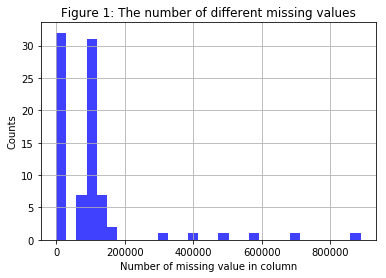

In [10]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(missing, bins=30, facecolor='b', alpha=0.75)
plt.xlabel('Number of missing value in column')
plt.ylabel('Counts')
plt.title('Figure 1: The number of different missing values')
plt.grid(True)
plt.show()

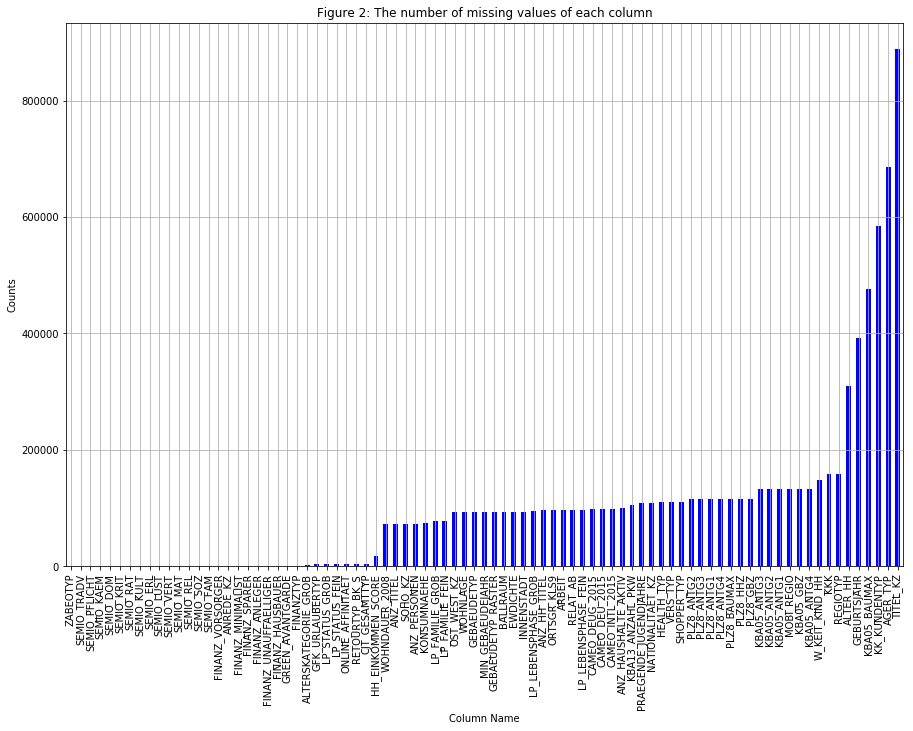

In [11]:
missing.sort_values(inplace=True)
missing.plot.bar(figsize=(15,10), color = 'b')
plt.xlabel('Column Name')
plt.ylabel('Counts')
plt.title('Figure 2: The number of missing values of each column')
plt.grid(True)
plt.show()

In [12]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
missing_col = missing_percent[missing_percent >= 0.2].index

In [13]:
missing_col

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')

In [14]:
azdias_new.drop(missing_col, axis = 1, inplace = True)

In [15]:
missing_percent[missing_percent >= 0.2]

AGER_TYP        0.769554
GEBURTSJAHR     0.440203
TITEL_KZ        0.997576
ALTER_HH        0.348137
KK_KUNDENTYP    0.655967
KBA05_BAUMAX    0.534687
dtype: float64

In [16]:
azdias_new.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

Most of features have missing values range from 0 to 20%, but there are six features which have over 20% missing values. These features are 'AGER_TYP', 'GEBURTSJAHR', 'KK_KUNDENTYP', 'TITEL_KZ', 'ALTER_HH', 'KBA05_BAUMAX'. They have 76.95%, 44.02%, 65.59%, 99.75%, 34.81% and 53.46% missing values, respectively. It is not possible to replace these missing values without bias so I delete them from the dataset.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

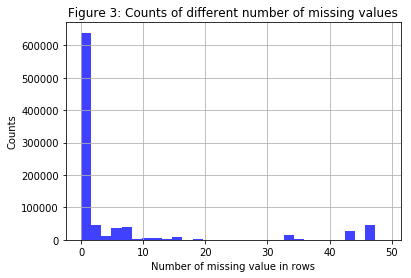

In [17]:
# How much data is missing in each row of the dataset?
missing_row = azdias_new.isnull().sum(axis = 1)
plt.hist(missing_row, bins=30, facecolor='b', alpha=0.75)
plt.xlabel('Number of missing value in rows')
plt.ylabel('Counts')
plt.title('Figure 3: Counts of different number of missing values')
plt.grid(True)
plt.show()

In [18]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_few = azdias_new[missing_row<20]
azdias_high = azdias_new[missing_row>20]

In [19]:
# Show the percentage of high missing rows
len(azdias_high)/len(azdias_new)

0.10524325616205184

In [20]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def compare_distribution(num):
    missing_smallest_attr = missing_percent.nsmallest(num).index
    fig, ax = plt.subplots(num, 2, figsize=(15, 30)) 
    ax[0,0].set_title('Few')
    ax[0,1].set_title('High')
    for i, attr in enumerate(missing_smallest_attr):
        sns.countplot(azdias_few[attr], ax=ax[i,0])
        sns.countplot(azdias_high[attr], ax=ax[i,1])

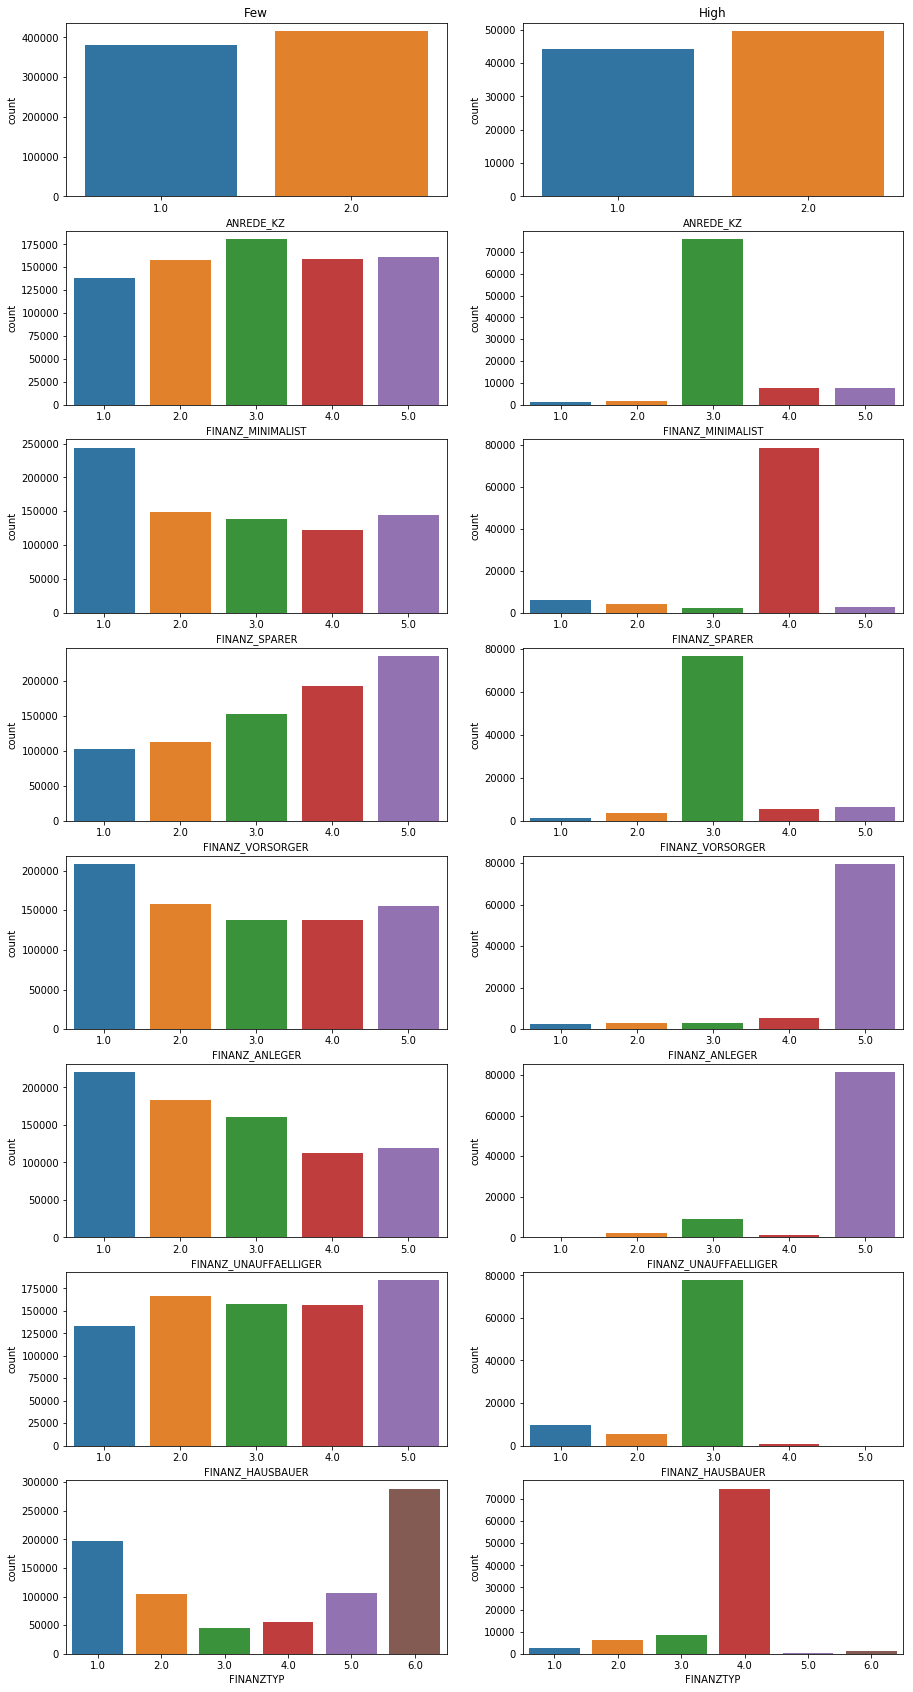

In [21]:
compare_distribution(8)

#### Discussion 1.1.3: Assess Missing Data in Each Row

We can see in Figure 3 that most of rows have less than 20 missing values so we set 20 as the threshold. 
In order to see if the distribution of data values on columns that are not missing data are similar or different between the two groups, we choose 8 columns in this experiment and make barplots to compare them. We can easily find they are different. So, it is not appropriate to replace these missing values and do analysis with them. And because there are only 10% of high missing value rows, I would like to choose to drop them in the following analysis. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [22]:
# Drop attributes which have lots of missing values in Feat_info dataset
miss_col_index = []
for i in missing_col:
    for j, attr in enumerate(feat_info['attribute']):
        if attr == i:
            miss_col_index.append(j)
feat_info.drop(miss_col_index, axis = 0, inplace = True)

In [23]:
# How many features are there of each data type?
# drop attributes which have lots of missing values
feat_info.groupby('type').count()

,attribute,information_level,missing_or_unknown
type,,,
categorical,18,18,18
mixed,6,6,6
numeric,6,6,6
ordinal,49,49,49


In [24]:
print(feat_info)

                attribute information_level         type missing_or_unknown
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
12        GFK_URLAUBERTYP            person  categorical                 []
13       GREEN_AVANTGARDE            person  categorical                 []
14          

In [25]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
feat_cat = feat_info[feat_info['type'] == 'categorical']

In [26]:
azdias_few[feat_cat['attribute']].head()

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
1,2.0,5.0,1.0,10.0,0,5.0,3.0,2.0,1.0,1.0,3.0,1.0,2.0,5.0,8.0,W,8.0,8A
2,2.0,3.0,1.0,10.0,1,1.0,1.0,3.0,2.0,1.0,2.0,0.0,1.0,5.0,1.0,W,4.0,4C
3,2.0,2.0,6.0,1.0,0,NaN,NaN,9.0,4.0,1.0,1.0,0.0,1.0,3.0,1.0,W,2.0,2A
4,1.0,5.0,5.0,5.0,0,10.0,5.0,3.0,2.0,1.0,2.0,0.0,2.0,4.0,1.0,W,6.0,6B
5,2.0,2.0,2.0,1.0,0,1.0,1.0,4.0,2.0,1.0,0.0,0.0,2.0,4.0,1.0,W,8.0,8C


In [27]:
binary_attr = []
multi_attr = []
for attr in feat_cat['attribute']:
    if len(azdias_few[attr].unique()) <= 2:
        binary_attr.append(attr)
    else:
        multi_attr.append(attr)
        
print('Binary variables are:', binary_attr)
print('Multi-level variables are:', multi_attr)

Binary variables are: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']
Multi-level variables are: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [28]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Change OST_WEST_KZ's values to 0&1
OST = {"O":0, "W":1}
azdias_few['OST_WEST_KZ'] = azdias_few['OST_WEST_KZ'].map(OST)

azdias_few.drop('CAMEO_DEU_2015', axis=1, inplace =True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [29]:
multi_attr.remove('CAMEO_DEU_2015')

In [30]:
# OneHotEncoder
azdias_few = pd.get_dummies(azdias_few, prefix = multi_attr, columns = multi_attr)

#### Discussion 1.2.1: Re-Encode Categorical Features

We change OST_WEST_KZ's values to 0 and 1 because it is binary variable. We drop 'CAMEO_DEU_2015' becasue there are 45 different variables and it is strongly correlated to 'CAMEO_DEUG_2015'. Then we change all multi-level categoricals into multiple dummy variables.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [31]:
feat_mix = feat_info[feat_info['type'] == 'mixed']
feat_mix

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


### Dictionary: PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

For 'PRAEGENDE_JUGENDJAHRE', we encode them by following rules:{40s:0, 50s:1, 60s:2, 70s:3, 80s:4, 90s:5},{Mainstream:0, Avantgarde:1}

In [32]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
decade = {1:0, 2:0, 3:1, 4:1, 5:2, 6:2, 7:2, 8:3, 9:3, 10:4, 11:4, 12:4, 13:4, 14:5, 15:5}
movement = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
azdias_few["Decade"] = azdias_few["PRAEGENDE_JUGENDJAHRE"].map(decade)
azdias_few["Movement"] = azdias_few["PRAEGENDE_JUGENDJAHRE"].map(movement)

In [33]:
azdias_few.drop("PRAEGENDE_JUGENDJAHRE", axis = 1, inplace = True)

### Dictionary: CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown


In [34]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# Set two function to encode these variables
def wealth(x):
    if x // 10 ==1:
        return 1
    if x // 10 ==2:
        return 2
    if x // 10 ==3:
        return 3
    if x // 10 ==4:
        return 4
    if x // 10 ==5:
        return 5
    
def life_stage(x):
    if x % 10 ==1:
        return 1
    if x % 10 ==2:
        return 2
    if x % 10 ==3:
        return 3
    if x % 10 ==4:
        return 4
    if x % 10 ==5:
        return 5

In [35]:
azdias_few["Wealth"] = azdias_few["CAMEO_INTL_2015"].apply(wealth)
azdias_few["Life_stage"] = azdias_few["CAMEO_INTL_2015"].apply(life_stage)

In [36]:
azdias_few.drop("CAMEO_INTL_2015", axis = 1, inplace = True)

In [37]:
azdias_few.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,Decade,Movement,Wealth,Life_stage
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,0,0,0,0,1,0,5.0,0.0,5.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,1,0,0,0,0,0,5.0,1.0,2.0,4.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0,2.0,...,0,0,0,0,0,0,3.0,0.0,1.0,2.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,0,0,1,0,0,0,3.0,0.0,4.0,3.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,0,0,0,0,1,0,1.0,0.0,5.0,4.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

We encode PRAEGENDE_JUGENDJAHRE into Decade and Movement and encode CAMEO_INTL_2015 into Wealth and Life_stage then drop two original attributes.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [38]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [39]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias_few.shape

(797077, 153)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [40]:
def wealth(x):
    if x // 10 ==1:
        return 1
    if x // 10 ==2:
        return 2
    if x // 10 ==3:
        return 3
    if x // 10 ==4:
        return 4
    if x // 10 ==5:
        return 5
    
def life_stage(x):
    if x % 10 ==1:
        return 1
    if x % 10 ==2:
        return 2
    if x % 10 ==3:
        return 3
    if x % 10 ==4:
        return 4
    if x % 10 ==5:
        return 5
    
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: df: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
    
    # convert missing value codes into NaNs, ...
    for col in range(df.shape[1]):
        col_name=df.columns[col]
        na_list=feat_info.iloc[col,3]
        na_list=na_list.replace('[', '')
        na_list=na_list.replace(']', '')
        na_list=na_list.split(',')
        if na_list == ['']:
            continue
        else:
            for na_value in na_list:
                if df[col_name].dtype =='object':
                    df.loc[df[col_name]==na_value,col_name]=np.nan 
                else:   
                    na_value=int(na_value)
                    df.loc[df[col_name]==na_value,col_name]=np.nan
                    
    # Save and Load dataset
    df.to_csv('converted.csv', sep=';', index = False)
    df = pd.read_csv('converted.csv', delimiter=';')
    
    # remove selected columns and rows, ...
    
    # missing = df.isnull().sum()
    # missing_percent = missing/len(df)
    # missing_col = missing_percent[missing_percent >= 0.2].index
    df.drop(missing_col, axis = 1, inplace = True)
    missing_row = df.isnull().sum(axis = 1)
    df = df[missing_row<20]
    
    # select, re-encode, and engineer column values.
    miss_col_index = []
    for i in missing_col:
        for j, attr in enumerate(feat_info['attribute']):
            if attr == i:
                miss_col_index.append(j)
    feat_info.drop(miss_col_index, axis = 0, inplace = True)
    feat_cat = feat_info[feat_info['type'] == 'categorical']
    
    binary_attr = []
    multi_attr = []
    for attr in feat_cat['attribute']:
        if len(df[attr].unique()) <= 2:
            binary_attr.append(attr)
        else:
            multi_attr.append(attr)
            
    OST = {"O":0, "W":1}
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map(OST)
    
    df.drop('CAMEO_DEU_2015', axis=1, inplace =True)
    multi_attr.remove('CAMEO_DEU_2015')
    
    df = pd.get_dummies(df, prefix = multi_attr, columns = multi_attr)
    
    decade = {1:0, 2:0, 3:1, 4:1, 5:2, 6:2, 7:2, 8:3, 9:3, 10:4, 11:4, 12:4, 13:4, 14:5, 15:5}
    movement = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
    df["Decade"] = df["PRAEGENDE_JUGENDJAHRE"].map(decade)
    df["Movement"] = df["PRAEGENDE_JUGENDJAHRE"].map(movement)
    df.drop("PRAEGENDE_JUGENDJAHRE", axis = 1, inplace = True)
    
    df["Wealth"] = df["CAMEO_INTL_2015"].apply(wealth)
    df["Life_stage"] = df["CAMEO_INTL_2015"].apply(life_stage)
    df.drop("CAMEO_INTL_2015", axis = 1, inplace = True)
    
    # Return the cleaned dataframe.
    return df

In [41]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

In [42]:
data = clean_data(azdias)

In [43]:
data.shape

(797077, 153)

Same as what we've done below!

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [44]:
from sklearn.preprocessing import Imputer, StandardScaler

In [45]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
fill_nan = Imputer(strategy = "most_frequent", missing_values = "NaN", axis = 0)
data_clean = fill_nan.fit_transform(data)

In [46]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
data_scale = scaler.fit_transform(data_clean)
data_scale = pd.DataFrame(data_scale, columns=list(data))
data_scale.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,Decade,Movement,Wealth,Life_stage
0,-1.766173,0.958121,-1.494463,1.538139,-1.040664,1.466401,0.959974,1.338532,-0.530654,1.010291,...,-0.386971,-0.272817,-0.391257,-0.329089,2.220562,-0.396186,1.098802,-0.530654,1.175857,-1.249369
1,0.200733,0.958121,-1.494463,0.864753,-1.766903,-0.570914,0.245238,1.338532,1.884467,1.010291,...,2.584170,-0.272817,-0.391257,-0.329089,-0.450336,-0.396186,1.098802,1.884467,-0.869590,0.766691
2,1.184186,0.958121,0.683285,-0.482020,1.138052,-0.570914,-1.184235,-0.792444,-0.530654,-0.311793,...,-0.386971,-0.272817,-0.391257,-0.329089,-0.450336,-0.396186,-0.267171,-0.530654,-1.551406,-0.577349
3,0.200733,-1.043709,0.683285,0.191366,0.411813,-1.250019,0.245238,-0.792444,-0.530654,1.010291,...,-0.386971,-0.272817,2.555867,-0.329089,-0.450336,-0.396186,-0.267171,-0.530654,0.494041,0.094671
4,-1.766173,0.958121,-0.042631,-1.155407,1.138052,-0.570914,-0.469499,1.338532,-0.530654,1.010291,...,-0.386971,-0.272817,-0.391257,-0.329089,2.220562,-0.396186,-1.633144,-0.530654,1.175857,0.766691


### Discussion 2.1: Apply Feature Scaling

As there is not too much missing data, we fill them with mode. And then we do feature scaling to all of these data.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [47]:
from sklearn.decomposition import PCA

In [48]:
# Apply PCA to the data.
pca = PCA()
data_pca = pca.fit_transform(data_scale)

In [49]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

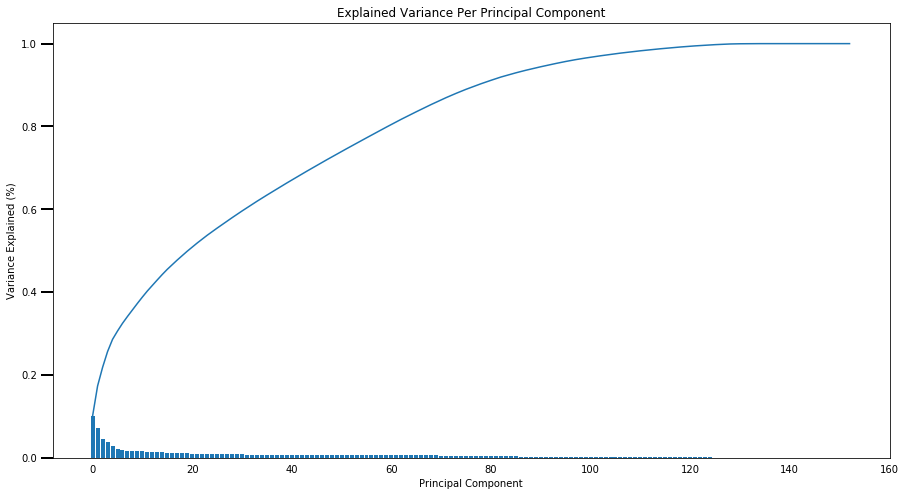

In [50]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)

In [51]:
# Re-apply PCA to the data while selecting for number of components to retain.
# We want to retain 90% information
pca_90 = PCA(n_components = 0.9)
data_pca = pca_90.fit_transform(data_scale)

In [52]:
pca_90.n_components_

79

### Discussion 2.2: Perform Dimensionality Reduction

We want to retain 90% information so we set number to 0.9, and we can see that it keeps 79 components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [53]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_results(full_dataset, pca, ith):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    
    variance_ratios_ith = variance_ratios.iloc[ith-1]
    components_ith = components.iloc[ith-1].sort_values(ascending = False)
    
    # plot the weight
    components_ith.plot.bar(figsize=(30, 15), color = 'b')
    plt.xlabel('Feature name', fontsize = 20)
    plt.ylabel('Weight', fontsize = 20)
    plt.title('The weight of each feature in %s'
              '\n'
              'Explained Variance is: %f' %(dimensions[ith-1], variance_ratios_ith.values), fontsize = 25)
    plt.grid(True)
    plt.show()
    
    # Return a concatenated DataFrame
    return variance_ratios_ith, components_ith

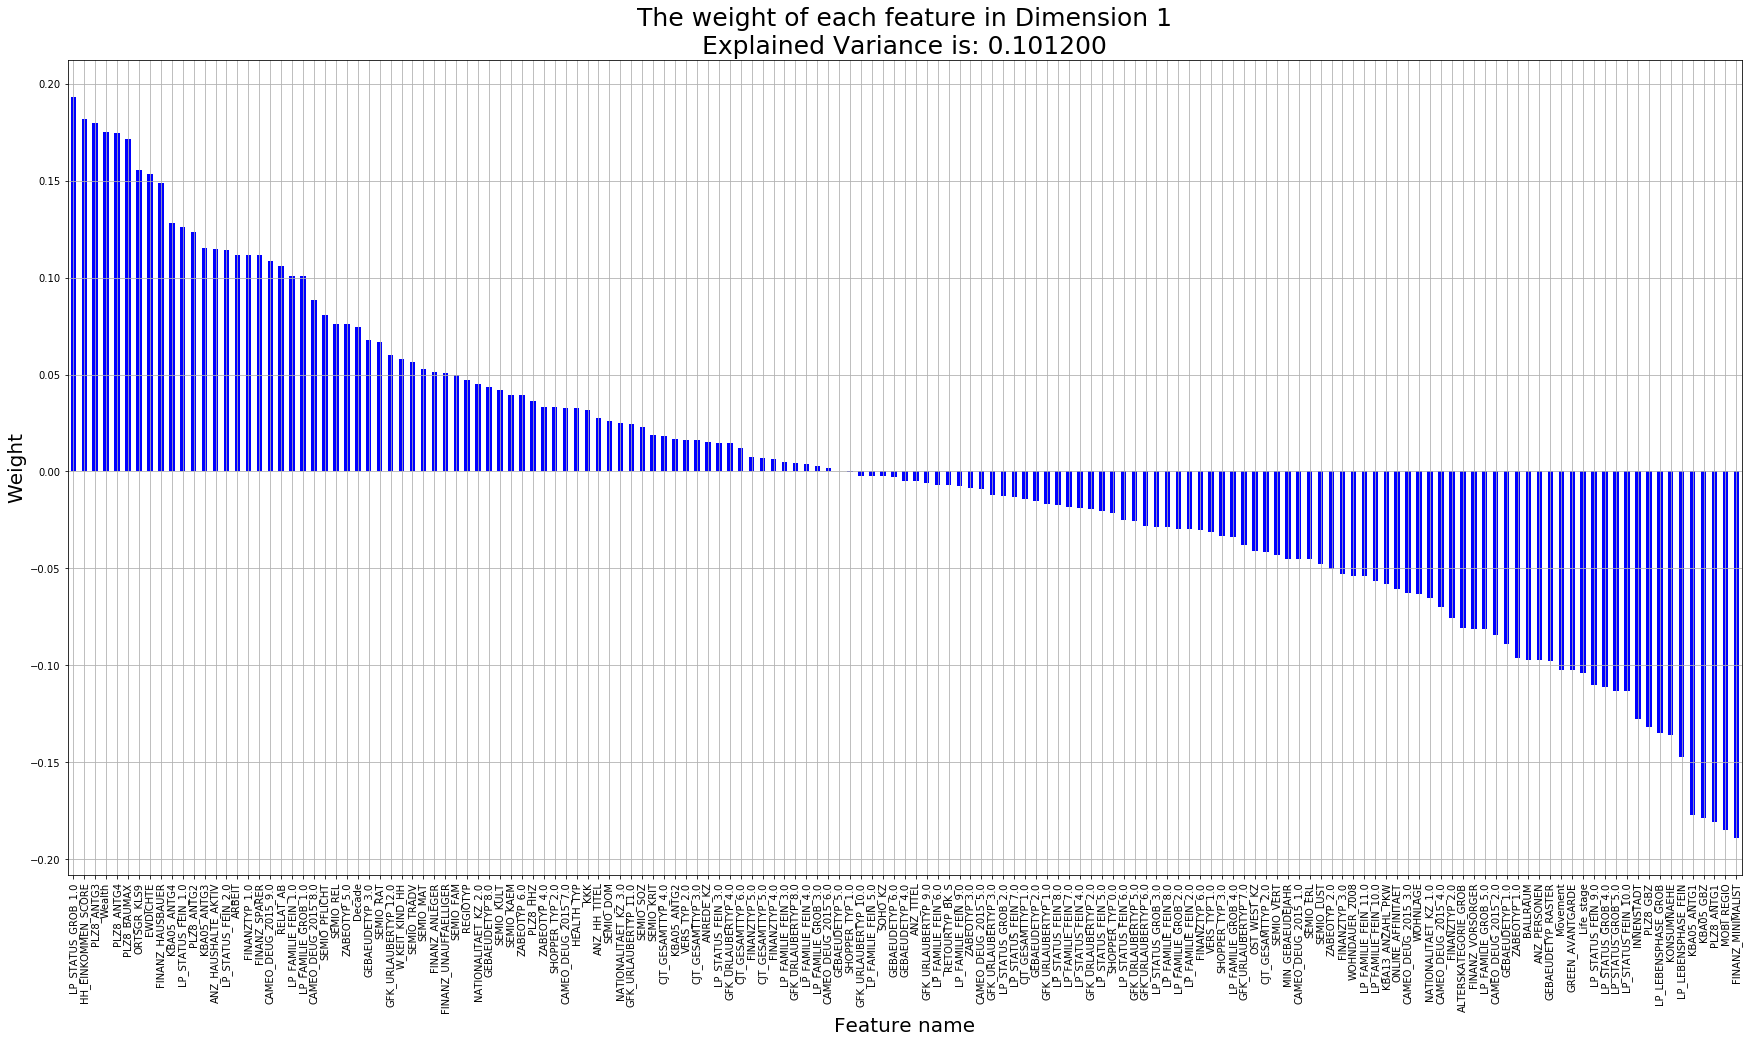

(Explained Variance    0.1012
 Name: Dimension 1, dtype: float64, LP_STATUS_GROB_1.0      0.1933
 HH_EINKOMMEN_SCORE      0.1817
 PLZ8_ANTG3              0.1799
 Wealth                  0.1752
 PLZ8_ANTG4              0.1746
 PLZ8_BAUMAX             0.1713
 ORTSGR_KLS9             0.1552
 EWDICHTE                0.1533
 FINANZ_HAUSBAUER        0.1486
 KBA05_ANTG4             0.1280
 LP_STATUS_FEIN_1.0      0.1259
 PLZ8_ANTG2              0.1234
 KBA05_ANTG3             0.1154
 ANZ_HAUSHALTE_AKTIV     0.1148
 LP_STATUS_FEIN_2.0      0.1140
 ARBEIT                  0.1115
 FINANZTYP_1.0           0.1115
 FINANZ_SPARER           0.1114
 CAMEO_DEUG_2015_9.0     0.1086
 RELAT_AB                0.1057
 LP_FAMILIE_FEIN_1.0     0.1010
 LP_FAMILIE_GROB_1.0     0.1010
 CAMEO_DEUG_2015_8.0     0.0882
 SEMIO_PFLICHT           0.0805
 SEMIO_REL               0.0763
 ZABEOTYP_5.0            0.0761
 Decade                  0.0746
 GEBAEUDETYP_3.0         0.0677
 SEMIO_RAT               0.0669
 GFK_UR

In [54]:
pca_results(data, pca_90, 1)

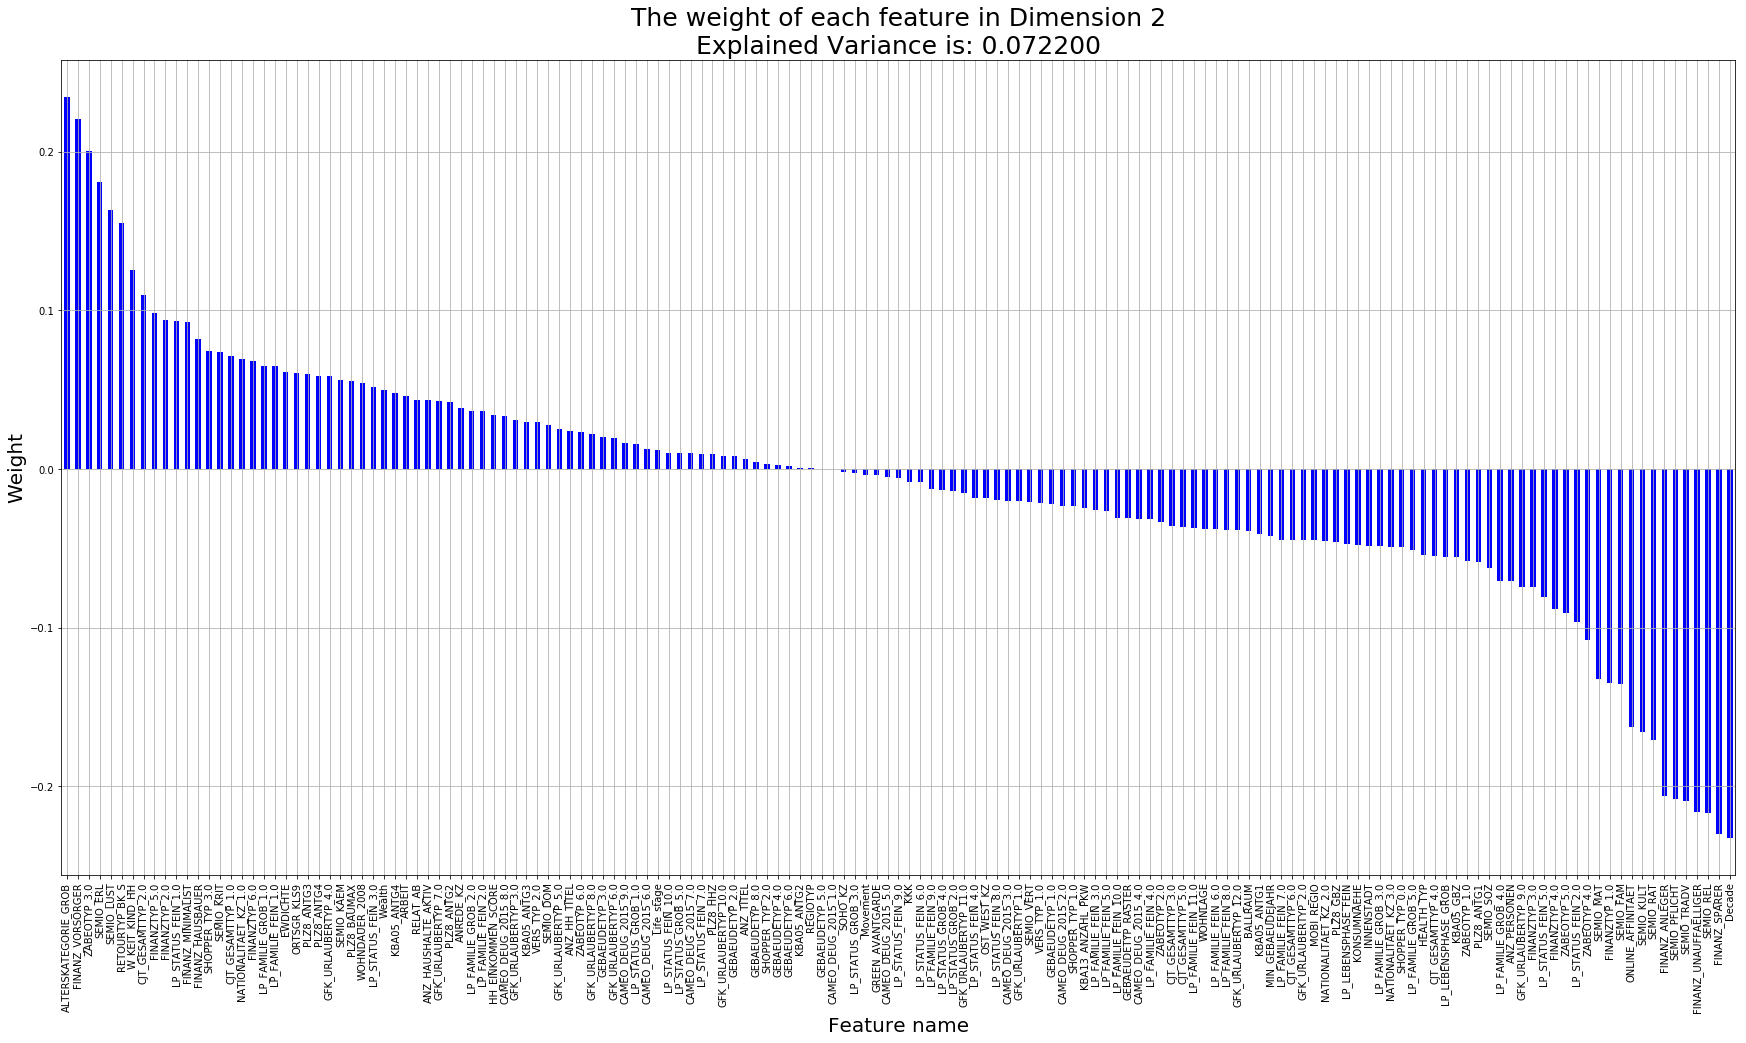

(Explained Variance    0.0722
 Name: Dimension 2, dtype: float64, ALTERSKATEGORIE_GROB     0.2347
 FINANZ_VORSORGER         0.2207
 ZABEOTYP_3.0             0.2001
 SEMIO_ERL                0.1807
 SEMIO_LUST               0.1635
 RETOURTYP_BK_S           0.1553
 W_KEIT_KIND_HH           0.1255
 CJT_GESAMTTYP_2.0        0.1098
 FINANZTYP_5.0            0.0985
 FINANZTYP_2.0            0.0938
 LP_STATUS_FEIN_1.0       0.0935
 FINANZ_MINIMALIST        0.0928
 FINANZ_HAUSBAUER         0.0821
 SHOPPER_TYP_3.0          0.0742
 SEMIO_KRIT               0.0736
 CJT_GESAMTTYP_1.0        0.0712
 NATIONALITAET_KZ_1.0     0.0696
 FINANZTYP_6.0            0.0680
 LP_FAMILIE_GROB_1.0      0.0649
 LP_FAMILIE_FEIN_1.0      0.0649
 EWDICHTE                 0.0613
 ORTSGR_KLS9              0.0604
 PLZ8_ANTG3               0.0597
 PLZ8_ANTG4               0.0589
 GFK_URLAUBERTYP_4.0      0.0587
 SEMIO_KAEM               0.0563
 PLZ8_BAUMAX              0.0552
 WOHNDAUER_2008           0.0541
 LP_STATUS_

In [55]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_results(data, pca_90, 2)

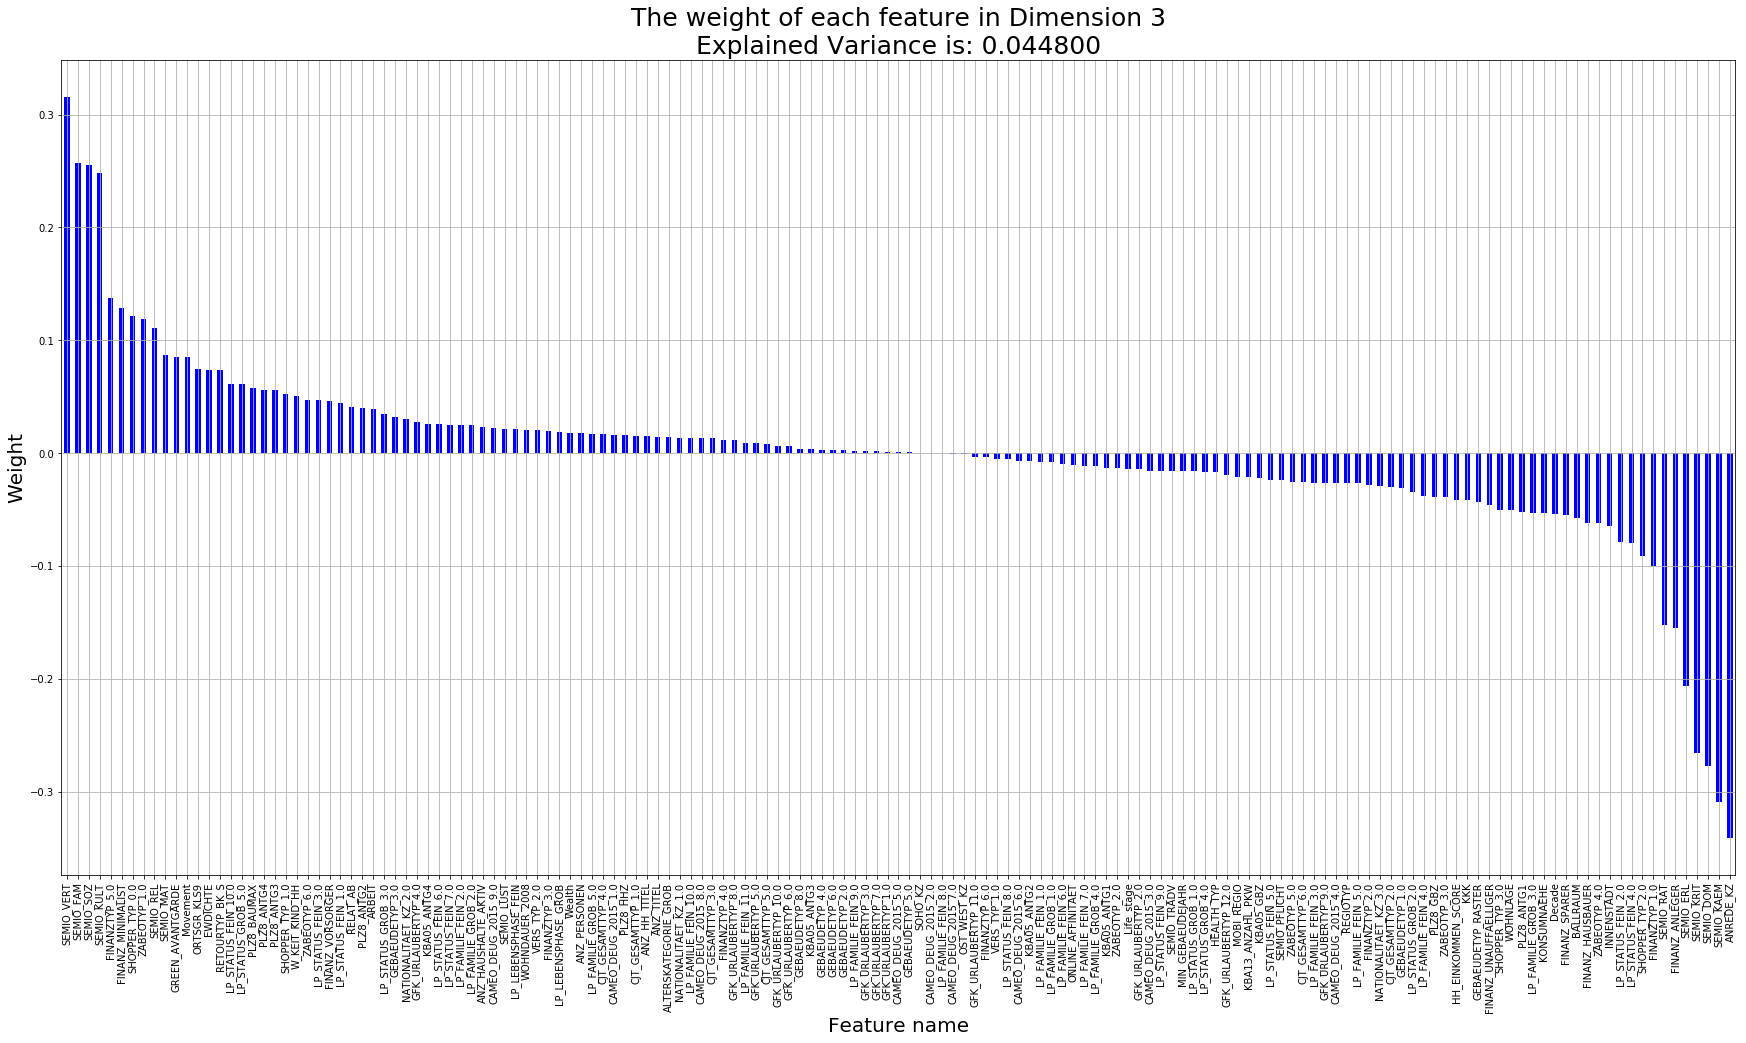

(Explained Variance    0.0448
 Name: Dimension 3, dtype: float64, SEMIO_VERT               0.3159
 SEMIO_FAM                0.2570
 SEMIO_SOZ                0.2556
 SEMIO_KULT               0.2485
 FINANZTYP_5.0            0.1374
 FINANZ_MINIMALIST        0.1287
 SHOPPER_TYP_0.0          0.1216
 ZABEOTYP_1.0             0.1186
 SEMIO_REL                0.1111
 SEMIO_MAT                0.0871
 GREEN_AVANTGARDE         0.0848
 Movement                 0.0848
 ORTSGR_KLS9              0.0748
 EWDICHTE                 0.0738
 RETOURTYP_BK_S           0.0736
 LP_STATUS_FEIN_10.0      0.0609
 LP_STATUS_GROB_5.0       0.0609
 PLZ8_BAUMAX              0.0579
 PLZ8_ANTG4               0.0561
 PLZ8_ANTG3               0.0557
 SHOPPER_TYP_1.0          0.0525
 W_KEIT_KIND_HH           0.0503
 ZABEOTYP_6.0             0.0473
 LP_STATUS_FEIN_3.0       0.0469
 FINANZ_VORSORGER         0.0463
 LP_STATUS_FEIN_1.0       0.0440
 RELAT_AB                 0.0408
 PLZ8_ANTG2               0.0404
 ARBEIT    

In [56]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_results(data, pca_90, 3)

### Discussion 2.3: Interpret Principal Components

We can see that:

the first component is mainly interpreted by household net income and financial level.

The second component is mainly interpreted by personal financial level and personality.

The third component is mainly interpreted by personality.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [57]:
from sklearn.cluster import KMeans 

In [58]:
# Over a number of different cluster counts...
def kmeans_score(data, n_cluster):

    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters = n_cluster)
    model = kmeans.fit(data)
    
    # compute the average within-cluster distances.
    score = np.abs(model.score(data))
    return score

In [60]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
scores = []
clusters = list(range(14,25))
for i in clusters:
    score = kmeans_score(data_pca, i)
    scores.append(score)

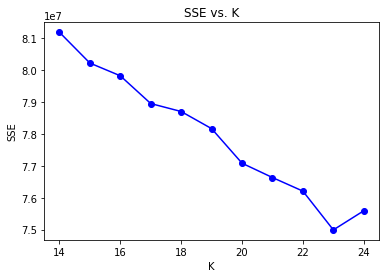

In [61]:
plt.plot(clusters, scores, marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [79]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 23)
model = kmeans.fit(data_pca)
azdias_cluster = model.predict(data_pca)

### Discussion 3.1: Apply Clustering to General Population

By using elbow method, I would like to use 23 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [80]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=";")

In [81]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
cust_clean = clean_data(customers)

In [82]:
cust_clean.shape

(141590, 152)

In [83]:
cust_clean.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,Decade,Movement,Wealth,Life_stage
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1,1.0,...,0,0,0,0,0,0,1.0,1.0,1.0,3.0
2,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1,2.0,...,0,1,0,0,0,0,1.0,1.0,3.0,4.0
3,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0,2.0,...,1,0,0,0,0,0,0.0,0.0,2.0,4.0
4,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0,3.0,...,0,0,0,1,0,0,3.0,0.0,4.0,1.0
5,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1,3.0,...,0,1,0,0,0,0,1.0,1.0,3.0,4.0


In [84]:
# Find the difference between cust_clean and data
set(list(cust_clean.columns)).symmetric_difference(set(list(data.columns)))

{'GEBAEUDETYP_5.0'}

In [85]:
cust_clean.insert(137, 'GEBAEUDETYP_5.0', 0)

In [86]:
cust_clean.shape

(141590, 153)

In [87]:
cust_columns = list(cust_clean)

In [88]:
cust_clean = fill_nan.transform(cust_clean)

In [89]:
scaler = StandardScaler()
cust_scale = scaler.fit_transform(cust_clean)
cust_scale = pd.DataFrame(cust_scale, columns=cust_columns)
cust_scale.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,Decade,Movement,Wealth,Life_stage
0,0.703936,-0.70280,0.723000,-0.516937,0.516188,-0.600675,0.138290,-0.553522,1.006178,-1.259484,...,-0.429462,-0.299427,-0.39016,-0.283786,-0.318482,-0.217312,-0.667340,1.006178,-1.140480,-0.266254
1,0.703936,1.42288,0.723000,-0.516937,0.516188,-0.600675,2.183668,0.965412,1.006178,0.026456,...,-0.429462,3.339708,-0.39016,-0.283786,-0.318482,-0.217312,-0.667340,1.006178,0.277565,0.476669
2,0.703936,-0.70280,0.723000,-0.516937,0.516188,0.397173,-0.884400,-0.553522,-0.993860,0.026456,...,2.328497,-0.299427,-0.39016,-0.283786,-0.318482,-0.217312,-1.396144,-0.993860,-0.431458,0.476669
3,-0.667139,-0.70280,-1.242075,-0.516937,-0.665858,2.392870,3.206358,-0.553522,-0.993860,1.312397,...,-0.429462,-0.299427,-0.39016,3.523782,-0.318482,-0.217312,0.790268,-0.993860,0.986587,-1.752100
4,-0.667139,-0.70280,0.723000,-0.516937,0.516188,-0.600675,0.138290,0.205945,1.006178,1.312397,...,-0.429462,3.339708,-0.39016,-0.283786,-0.318482,-0.217312,-0.667340,1.006178,0.277565,0.476669


In [90]:
cust_scale.shape

(141590, 153)

In [91]:
cust_pca = pca_90.transform(cust_scale)
cust_cluster = model.predict(cust_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [92]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
general_prop = []
customer_prop = []
for key in sorted(dict(Counter(azdias_cluster)).keys()):
    general_prop.append(dict(Counter(azdias_cluster))[key])
for key in sorted(dict(Counter(cust_cluster)).keys()):
    customer_prop.append(dict(Counter(cust_cluster))[key])

In [93]:
# Get the proportion of data in each cluster
general_prop = general_prop / np.sum(general_prop)*100
customer_prop = customer_prop/ np.sum(customer_prop)*100

In [94]:
index = np.arange(len(dict(Counter(azdias_cluster))))+1

In [95]:
df = pd.DataFrame(index = index, columns = pd.Index(['general_prop', 'customer_prop']))

In [96]:
df['general_prop'] = general_prop
df['customer_prop'] = customer_prop
df['difference'] = customer_prop - general_prop

In [97]:
# Dataset for analysis
df

,general_prop,customer_prop,difference
1,4.494923,11.586976,7.092053
2,3.704535,4.423335,0.718800
3,3.870141,3.740377,-0.129763
4,2.090011,0.546649,-1.543363
5,3.708801,10.812911,7.104109
6,6.049102,2.296772,-3.752330
7,7.901746,6.969419,-0.932327
8,4.773943,2.952186,-1.821757
9,5.761551,4.440992,-1.320560
10,6.112709,2.586341,-3.526368


In [98]:
df_2 = pd.DataFrame(index = np.arange(46), columns = pd.Index(['cluster', 'proportion', 'variable']))

In [99]:
for i, value in enumerate(df['general_prop']):
    df_2['cluster'].iloc[i] = i+1
    df_2['proportion'].iloc[i] = df['general_prop'].iloc[i]
    df_2['variable'].iloc[i] = 'general_prop'
for i, value in enumerate(df['customer_prop']):
    df_2['cluster'].iloc[i+23] = i+1
    df_2['proportion'].iloc[i+23] = df['customer_prop'].iloc[i]
    df_2['variable'].iloc[i+23] = 'customer_prop'

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [100]:
# Dataset for drawing the plot
df_2

,cluster,proportion,variable
0,1,4.49492,general_prop
1,2,3.70454,general_prop
2,3,3.87014,general_prop
3,4,2.09001,general_prop
4,5,3.7088,general_prop
5,6,6.0491,general_prop
6,7,7.90175,general_prop
7,8,4.77394,general_prop
8,9,5.76155,general_prop
9,10,6.11271,general_prop


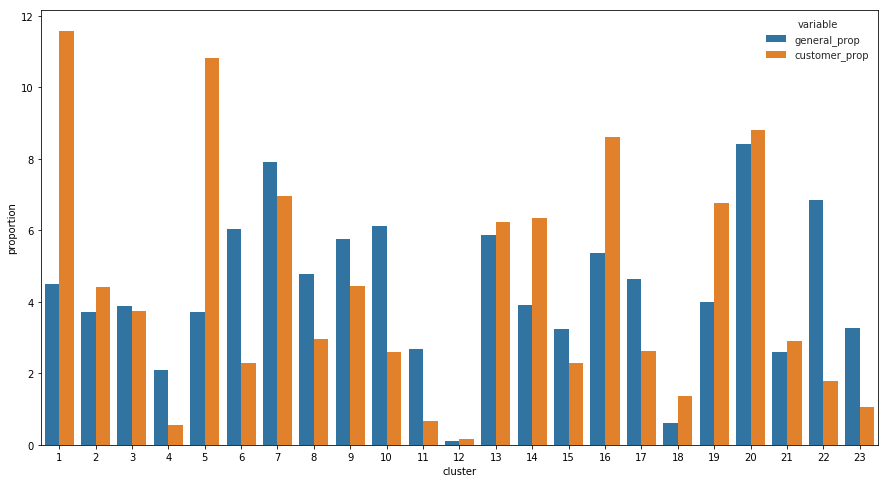

In [101]:
fig, axes = plt.subplots(1,1,figsize=(15, 8), sharex=True)
sns.set_style("whitegrid")
sns.barplot(x=df_2.cluster, y=df_2.proportion, hue=df_2.variable, palette=sns.color_palette(), zorder=2)

In [102]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
df.sort_values(by="difference" , ascending=False)

,general_prop,customer_prop,difference
5,3.708801,10.812911,7.104109
1,4.494923,11.586976,7.092053
16,5.364852,8.620665,3.255813
19,3.985060,6.775196,2.790136
14,3.923586,6.338018,2.414432
18,0.600820,1.355322,0.754501
2,3.704535,4.423335,0.718800
20,8.405587,8.800763,0.395176
13,5.874715,6.234904,0.360189
21,2.583314,2.904160,0.320846


In [103]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
df.sort_values(by="difference" , ascending=True)

,general_prop,customer_prop,difference
22,6.856301,1.796031,-5.060270
6,6.049102,2.296772,-3.752330
10,6.112709,2.586341,-3.526368
23,3.267062,1.048097,-2.218965
11,2.683304,0.667420,-2.015884
17,4.624773,2.628010,-1.996762
8,4.773943,2.952186,-1.821757
4,2.090011,0.546649,-1.543363
9,5.761551,4.440992,-1.320560
15,3.252132,2.299597,-0.952535


In [126]:
# Clusters that is overrepresented in the customer data compared to the general population
centroid_5 = pca_90.inverse_transform(model.cluster_centers_[4])
cust_over_general = pd.Series(data = centroid_5, index=cust_columns)
cust_over_general.sort_values(ascending = False)

LP_STATUS_GROB_5.0      2.251420
LP_STATUS_FEIN_10.0     2.251420
GREEN_AVANTGARDE        1.894803
Movement                1.894803
FINANZ_MINIMALIST       1.204467
ZABEOTYP_1.0            1.031706
SEMIO_VERT              0.986109
KBA05_ANTG1             0.875330
MOBI_REGIO              0.795755
KBA05_GBZ               0.747271
LP_FAMILIE_GROB_2.0     0.691138
LP_FAMILIE_FEIN_2.0     0.691138
FINANZTYP_5.0           0.680790
SEMIO_SOZ               0.550754
W_KEIT_KIND_HH          0.543077
PLZ8_ANTG1              0.533935
CAMEO_DEUG_2015_2.0     0.493549
SEMIO_KULT              0.486460
PLZ8_GBZ                0.463583
SEMIO_FAM               0.457317
FINANZ_VORSORGER        0.456464
Life_stage              0.438746
CAMEO_DEUG_2015_1.0     0.436567
GEBAEUDETYP_1.0         0.382798
ALTERSKATEGORIE_GROB    0.356210
SHOPPER_TYP_0.0         0.332878
SEMIO_LUST              0.325085
RETOURTYP_BK_S          0.318463
FINANZTYP_3.0           0.293073
GFK_URLAUBERTYP_7.0     0.285074
          

In [127]:
centroid_1 = pca_90.inverse_transform(model.cluster_centers_[0])
cust_over_general = pd.Series(data = centroid_1, index=cust_columns)
cust_over_general.sort_values(ascending = False)

LP_STATUS_FEIN_10.0     2.321755
LP_STATUS_GROB_5.0      2.321755
GREEN_AVANTGARDE        1.892283
Movement                1.892283
LP_FAMILIE_GROB_5.0     1.815324
LP_LEBENSPHASE_GROB     1.764963
LP_LEBENSPHASE_FEIN     1.752102
ANZ_PERSONEN            1.448329
LP_FAMILIE_FEIN_11.0    1.226095
LP_FAMILIE_FEIN_10.0    1.222958
FINANZ_MINIMALIST       1.026699
ZABEOTYP_1.0            0.969768
KBA05_ANTG1             0.952159
MOBI_REGIO              0.883690
ONLINE_AFFINITAET       0.785973
KBA05_GBZ               0.735619
FINANZTYP_3.0           0.674805
PLZ8_ANTG1              0.652202
ZABEOTYP_2.0            0.591377
CAMEO_DEUG_2015_2.0     0.558940
GEBAEUDETYP_1.0         0.492559
PLZ8_GBZ                0.487439
Life_stage              0.438035
WOHNDAUER_2008          0.422852
SEMIO_VERT              0.398822
CAMEO_DEUG_2015_1.0     0.380494
GEBAEUDETYP_RASTER      0.374433
KONSUMNAEHE             0.356676
OST_WEST_KZ             0.312963
NATIONALITAET_KZ_1.0    0.248968
          

In [128]:
# Clusters that is underrepresented in the customer data compared to the general population
centroid_22 = pca_90.inverse_transform(model.cluster_centers_[21])
cust_under_general = pd.Series(data = centroid_22, index=cust_columns)
cust_under_general.sort_values(ascending = False)

SEMIO_KULT               1.472979
SEMIO_FAM                1.460883
SEMIO_SOZ                1.304533
SEMIO_REL                1.274240
FINANZ_SPARER            1.241875
ZABEOTYP_5.0             1.025314
Decade                   1.002245
SEMIO_VERT               0.980830
FINANZ_UNAUFFAELLIGER    0.955181
LP_STATUS_GROB_1.0       0.914475
FINANZTYP_1.0            0.894740
LP_STATUS_FEIN_2.0       0.822349
SEMIO_PFLICHT            0.812427
SEMIO_TRADV              0.715921
SEMIO_MAT                0.709659
PLZ8_ANTG3               0.686542
HH_EINKOMMEN_SCORE       0.680781
PLZ8_ANTG4               0.666815
Wealth                   0.661918
PLZ8_BAUMAX              0.652337
ORTSGR_KLS9              0.608526
EWDICHTE                 0.571435
FINANZ_ANLEGER           0.538382
SHOPPER_TYP_0.0          0.528504
KBA05_ANTG3              0.511388
CAMEO_DEUG_2015_9.0      0.493492
CJT_GESAMTTYP_4.0        0.479511
FINANZTYP_4.0            0.469815
PLZ8_ANTG2               0.468449
KBA05_ANTG4   

In [129]:
centroid_6 = pca_90.inverse_transform(model.cluster_centers_[5])
cust_under_general = pd.Series(data = centroid_6, index=cust_columns)
cust_under_general.sort_values(ascending = False)

LP_STATUS_FEIN_2.0       1.566343
FINANZTYP_1.0            1.394923
FINANZ_SPARER            1.176731
FINANZ_ANLEGER           1.142552
SEMIO_RAT                1.131738
LP_STATUS_GROB_1.0       1.000178
FINANZ_UNAUFFAELLIGER    0.990726
Decade                   0.947226
SEMIO_PFLICHT            0.900583
ANREDE_KZ                0.880733
SEMIO_TRADV              0.810733
SEMIO_DOM                0.806177
SEMIO_KAEM               0.769684
ZABEOTYP_5.0             0.733419
FINANZ_HAUSBAUER         0.703848
SEMIO_REL                0.627670
HH_EINKOMMEN_SCORE       0.548810
KBA05_ANTG2              0.542631
SEMIO_KRIT               0.526536
ZABEOTYP_4.0             0.477132
LP_FAMILIE_GROB_1.0      0.378721
LP_FAMILIE_FEIN_1.0      0.378721
SEMIO_MAT                0.363004
PLZ8_GBZ                 0.335138
GFK_URLAUBERTYP_12.0     0.331571
KBA05_ANTG3              0.321190
SHOPPER_TYP_2.0          0.307811
NATIONALITAET_KZ_3.0     0.276242
HEALTH_TYP               0.261514
KBA13_ANZAHL_P

We can use scaler.inverse_transform(centroid_X) to compare the clusters directly with the raw data.

### Discussion 3.3: Compare Customer Data to Demographics Data
After analyzing the clusters, we can see that people in cluster 1 and cluster 5 are overrepresented in the customer data compared to the general population. And People in cluster 6 and cluster 22 are underrepresented in the customer data compared to the general population.

When I look at cluster 1 and 5 (these people are popular with the company), which have positive features for Social Status and Membership in environmental sustainability as part of youth, and negative features for Estimated household net income and home ownership typology. I infer that these people belong to high salary, member of green avantgarde, high estimated household net income, green energy consumption type, multiperson household type.

When I look at cluster 6 and 22 (these people are unpopular with the company), which have positive features for orientation-seeking low-income earners social status, low financial interest and money-saver financial type and some specific personality type, and negative features for some specific personality type and gender. I infer that these people belong to male, low salary, low socially-minded, low family minded, low cultural minded, high event oriented, low financial interest, not money saver and investor. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.